In [50]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
from image_processing import *

In [ ]:
text = iio.imread("images/lorem_ipsum.png")

In [52]:
text = gray(text)

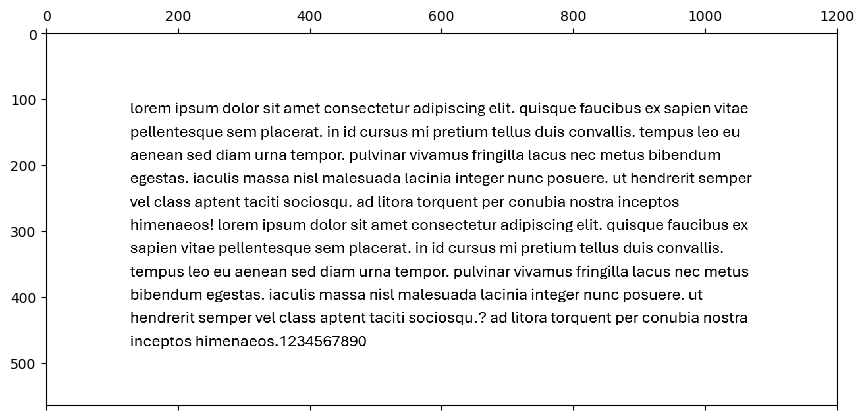

In [53]:
plt.matshow(text, 1, cmap="gist_gray")
plt.show()

In [54]:
from skimage import feature
import skimage.transform as transform

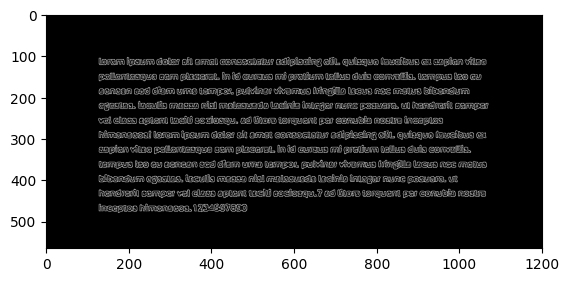

In [77]:
plt.imshow(feature.canny(text, sigma=2), cmap="gist_gray")
plt.show()

In [56]:
def hough_transform_2(image: np.ndarray):
    min_theta = 0
    max_theta = np.pi/2
    rho = 9
    theta = 0.2
    threshold = 400

    image = feature.canny(image, sigma=3)
    diagonal = np.sqrt(image.shape[0]**2 + image.shape[1]**2)

    theta_angles = np.arange(min_theta, max_theta, theta)
    rho_values = np.arange(-diagonal, diagonal, rho)

    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)

    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    accumulator = np.zeros([num_rhos, num_thetas])

    xs, ys = np.where(image > 0)
    
    for x,y in zip(xs,ys):
        for t in range(num_thetas):
            current_rho = x * coss[t] + y * sins[t]
            rho_pos = np.where(current_rho > rho_values)[0][-1]
            accumulator[rho_pos, t] += 1
    
    plt.matshow(accumulator)
    plt.show()
    print(np.max(accumulator), np.min(accumulator))
    
    final_rho_index, final_theta_index = np.where(accumulator > threshold)
    final_rho = rho_values[final_rho_index]    
    final_theta = theta_angles[final_theta_index]

    return np.vstack([final_rho, final_theta]).T

In [57]:
def hough_transform_3(image):
    acc, angles, d = transform.hough_line(feature.canny(image, sigma=5))
    
    plt.matshow(acc, aspect=0.1)
    plt.show()

    acc, angles, d = transform.hough_line_peaks(acc, angles, d, threshold=0.6*np.max(acc))

    return np.vstack([d, angles]).T

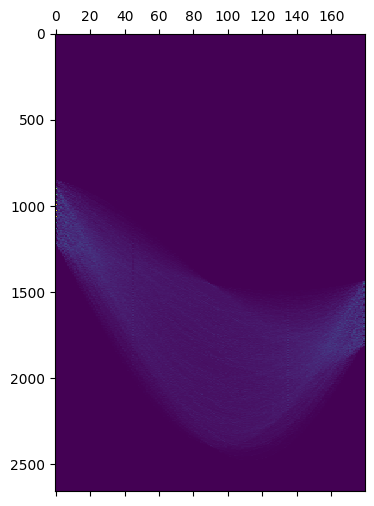

In [58]:
lines = hough_transform_3(text)

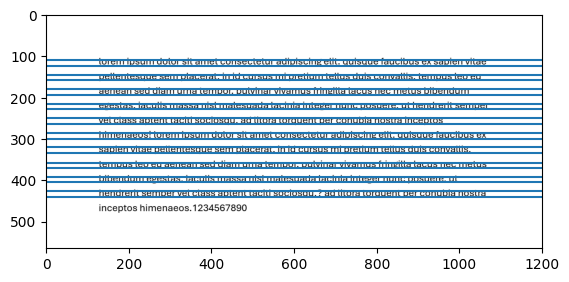

In [59]:
def polar2cartesian(radius, angle):
    return radius * np.array([np.cos(angle), np.sin(angle)])

for rho, theta in lines:
        x0 = polar2cartesian(rho, theta)
        direction = np.array([x0[1], -x0[0]])
        pt1 = np.round(x0 + 1000*direction).astype(int)
        pt2 = np.round(x0 - 1000*direction).astype(int)
        plt.axline(pt1, pt2)
plt.imshow(text, cmap="gist_gray")
plt.show()

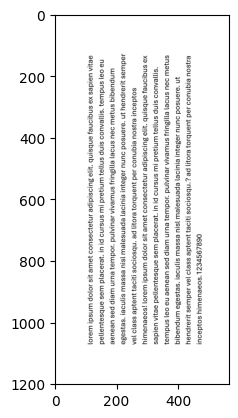

In [60]:
new_img = transform.rotate(text, 90, resize = True, mode = "edge")
plt.imshow(new_img, cmap="gist_gray")
plt.show()

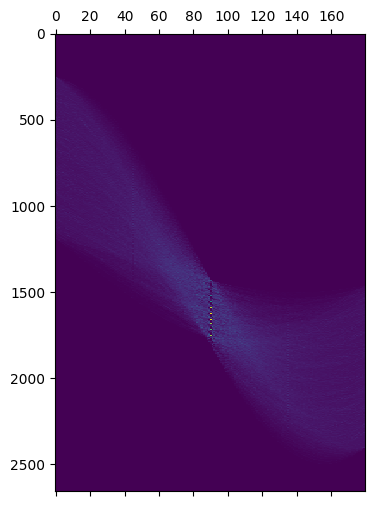

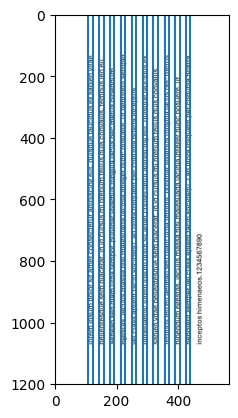

In [61]:
lines2 = hough_transform_3(new_img)

def polar2cartesian(radius, angle):
    return radius * np.array([np.cos(angle), np.sin(angle)])

for rho, theta in lines2:
        x0 = polar2cartesian(rho, theta)
        direction = np.array([x0[1], -x0[0]])
        pt1 = np.round(x0 + 1000*direction).astype(int)
        pt2 = np.round(x0 - 1000*direction).astype(int)
        plt.axline(pt1, pt2)
plt.imshow(new_img, cmap="gist_gray")
plt.show()

In [62]:
un_rotated = transform.rotate(new_img, 270 + np.rad2deg(lines2[0, 1]), resize = True, mode = "edge")

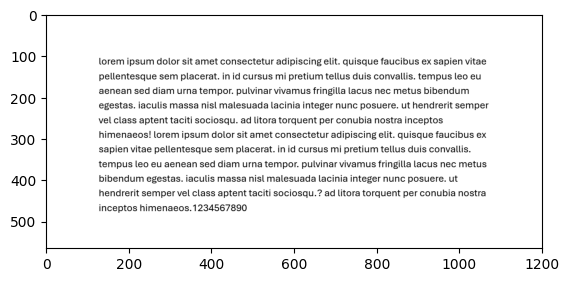

In [63]:
plt.imshow(un_rotated, cmap="gist_gray")
plt.show()

In [64]:
first = np.argmax(feature.canny(un_rotated, sigma=5), axis = 1)
first = first[first > 0]
last = np.argmax(np.rot90(np.rot90(feature.canny(un_rotated, sigma=5))), axis = 1)
last = last[last > 0]

In [65]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

In [66]:
out_f = reject_outliers(first)
out_l = reject_outliers(last)

In [67]:
if abs(max(out_f) - min(out_f)) > abs(max(out_l) - min(out_l)):
    un_rotated = transform.rotate(un_rotated, 180, resize = True, mode = "edge")

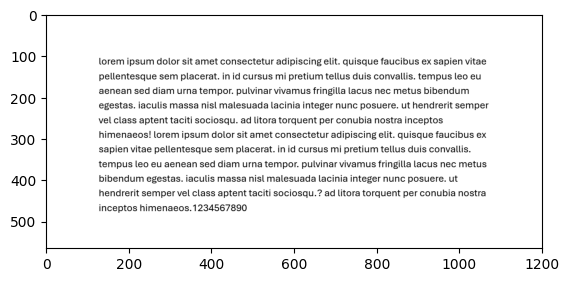

In [68]:
plt.imshow(un_rotated, cmap="gist_gray")
plt.show()

In [69]:
import skimage as skimage
import scipy.ndimage as ndimage

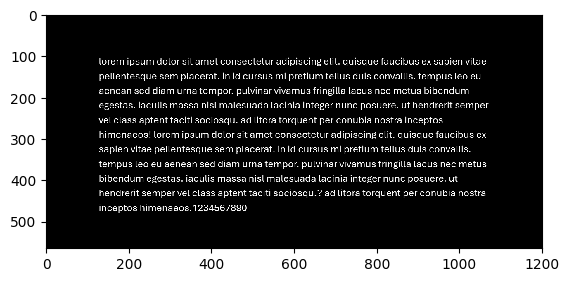

In [72]:
plt.imshow(flip(un_rotated), cmap="gist_gray", interpolation="nearest")
plt.show()

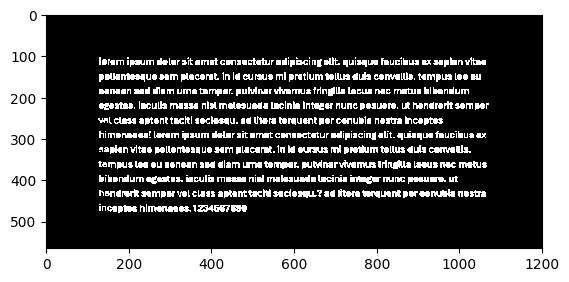

In [73]:
plt.imshow(ndimage.binary_fill_holes(flip(un_rotated)), cmap="gist_gray", interpolation="nearest")
plt.show()

In [ ]:
holeless = ndimage.binary_fill_holes(flip(un_rotated))

In [74]:
contours = skimage.measure.find_contours(flip(un_rotated))

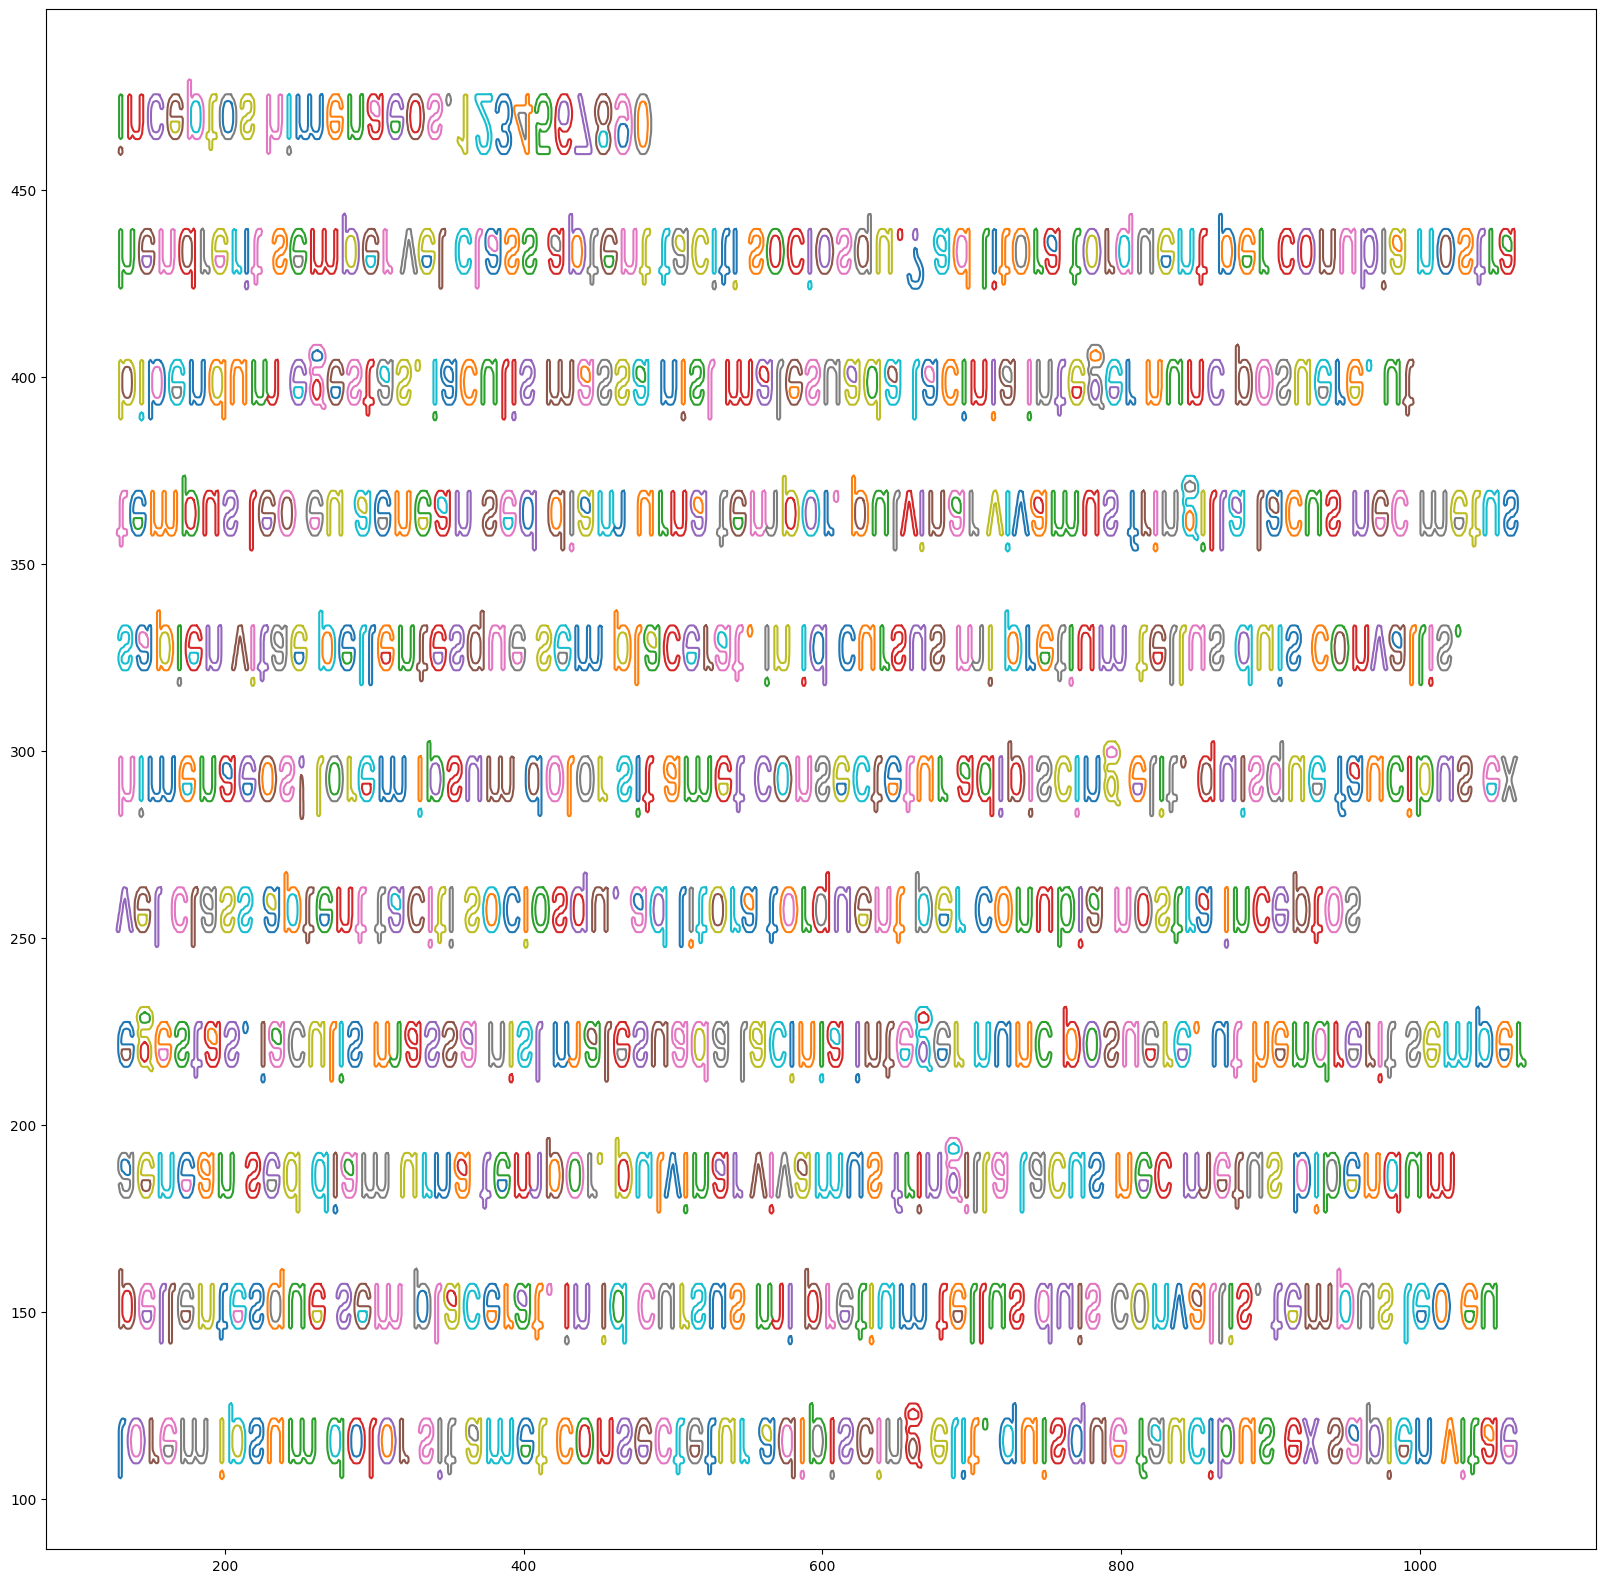

In [75]:
plt.figure(figsize=(20, 20))
for countour in contours:
    plt.plot(countour[:, 1], countour[:, 0])
plt.show()

In [78]:
import cv2 as cv

In [218]:
contours2, _ = cv.findContours(cv.Canny(flip(un_rotated).astype(np.uint8),190,240),cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

In [228]:
boxes = []
for cnt in contours2:
    if cv.contourArea(cnt)>1:
        boxes.append(cv.boundingRect(cnt))

In [220]:
from matplotlib.patches import Rectangle

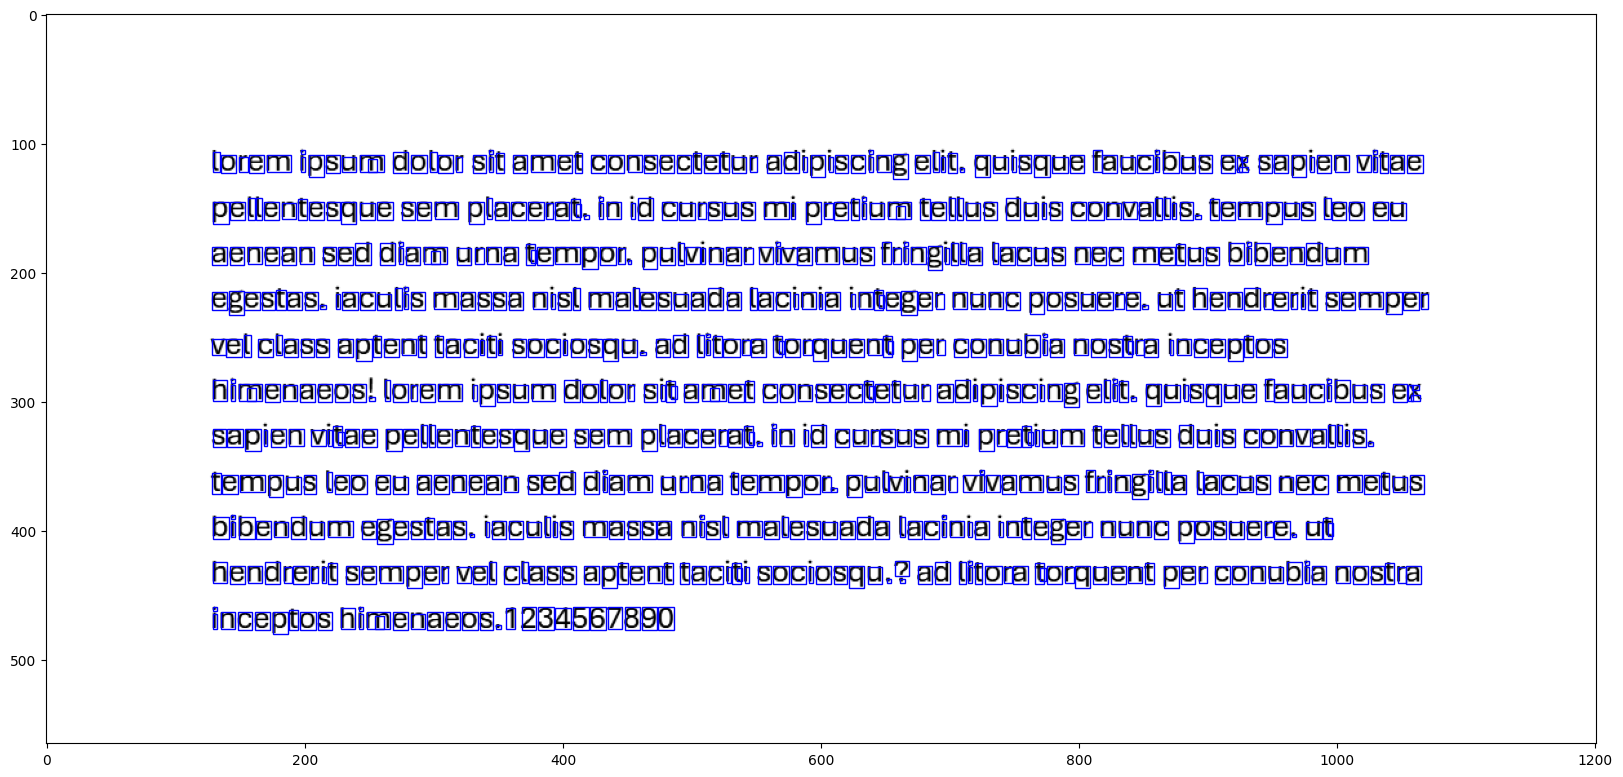

In [229]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.imshow(un_rotated, cmap="gist_gray")
for x, y, w, h in boxes:
    ax.add_patch(Rectangle((x, y), w, h, lw = 1, fill = False, edgecolor = "blue"))

In [253]:
def find_blank_lines(projection):
    lines = []
    top = 0
    for i in range(1, len(projection)):
        if projection[i-1] == 0 and projection[i]>0:
            top = i-1
        elif projection[i-1] > 0 and projection[i] == 0:
            lines.append((top, i))
    return lines

In [242]:
def bouding_boxes(image, show = False):
    vertical = np.sum(image, axis = 1)
    boxes = []
    for top, bottom in find_blank_lines(vertical):
        line_img = image[top:bottom, :]
        horizontal = np.sum(line_img, axis = 0)
        for left, right in find_blank_lines(horizontal):
            x, y = left, bottom
            w = right - left
            h = top - bottom
            boxes.append((x, y, w, h))
    return boxes

In [249]:
gray_img = flip(un_rotated)
gray_img[gray_img < 150] = 0

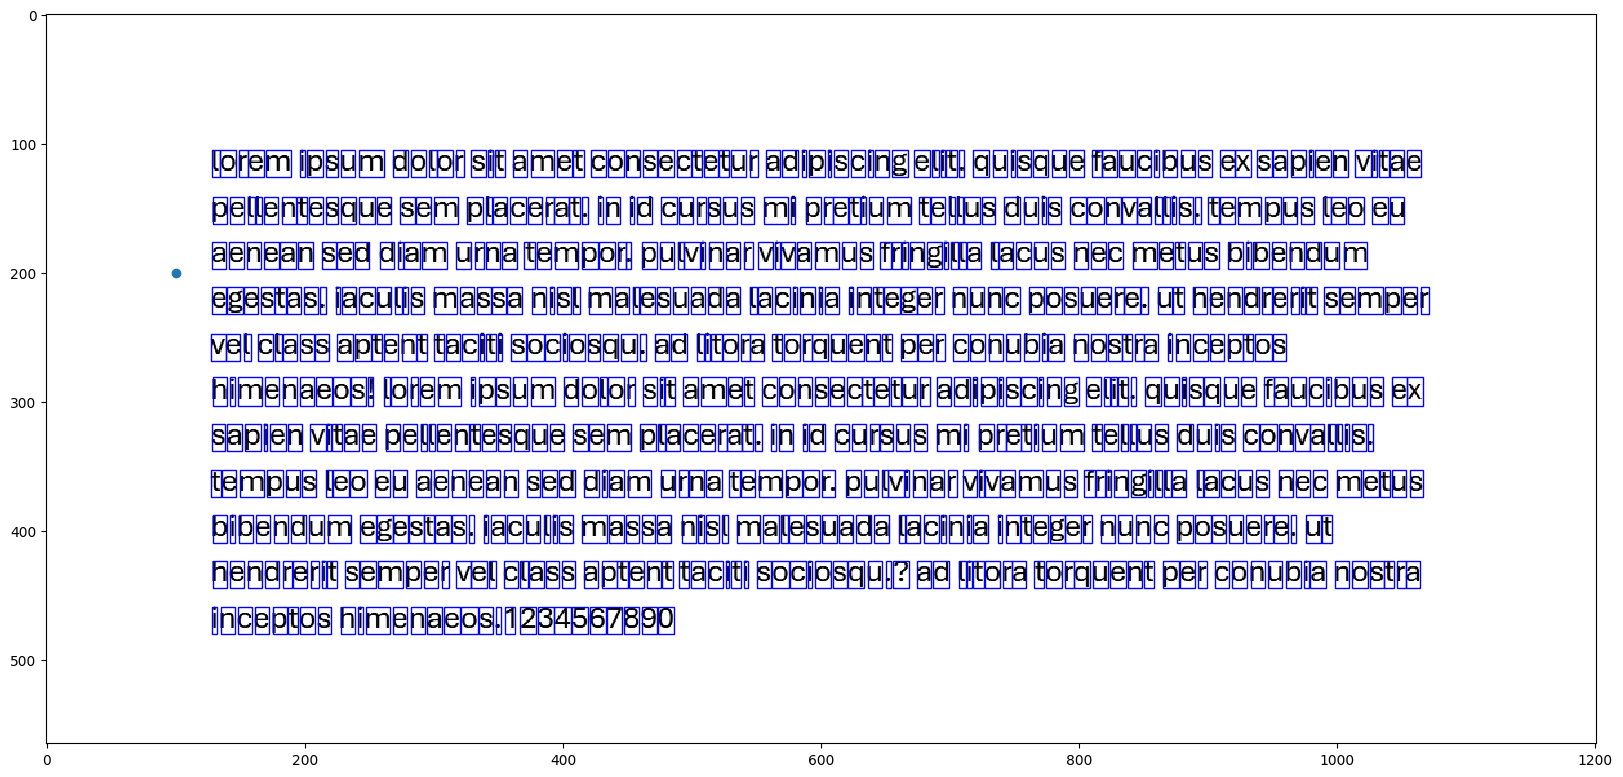

In [255]:
fig, ax = plt.subplots(figsize = (20, 10))
ax.imshow(un_rotated, cmap="gist_gray", interpolation="nearest")
for x, y, w, h in bouding_boxes(gray_img):
    ax.add_patch(Rectangle((x, y), w, h, lw = 1, fill = False, edgecolor = "blue"))
ax.scatter([100], [200])